In [2]:
%cd FasterRCNN-Torchvision-FineTuning

C:\Users\Shashwat\ModelDirectory\FasterRCNN-Torchvision-FineTuning


In [4]:
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

In [5]:
image_folder = '../Dataset/train2017/train2017'
annotations_file = '../Dataset/annotations_trainval2017/annotations/instances_train2017.json'

In [8]:
import os
import cv2
import json
import torch
from torch.utils.data import Dataset
from collections import defaultdict
from PIL import Image
import torchvision.transforms as T
from torchvision import ops
import matplotlib.patches as patches

In [9]:
class CocoDataset(Dataset):
    def __init__(self, image_folder, annotations_file, width, height, transforms=None):
        self.transforms = transforms
        self.image_folder = image_folder
        self.annotations_file = annotations_file
        self.height = height
        self.width = width

        if not isinstance(self.image_folder, str):
            raise ValueError("image_folder should be a string")

        if not isinstance(annotations_file, str):
            raise ValueError("annotations_file should be a string")

        with open(annotations_file, "r") as f:
            self.annotations = json.load(f)

        self.image_ids = defaultdict(list)
        for i in self.annotations["images"]:
            self.image_ids[i["id"]] = i  # key = image_id

        self.annotation_ids = defaultdict(list)
        for i in self.annotations["annotations"]:
            self.annotation_ids[i["image_id"]].append(i)  # key = image_id

        self.cats_id2label = {}
        self.label_names = []

        first_label_id = self.annotations["categories"][0]["id"]
        if first_label_id == 0:
            for i in self.annotations["categories"][1:]:
                self.cats_id2label[i["id"]] = i["name"]
                self.label_names.append(i["name"])
        elif first_label_id == 1:
            for i in self.annotations["categories"]:
                self.cats_id2label[i["id"]] = i["name"]
                self.label_names.append(i["name"])
        else:
            raise AssertionError("Something went wrong in categories, check the annotation file!")

    def get_total_classes_count(self):
        return len(self.cats_id2label)

    def get_classnames(self):
        return [v for k, v in self.cats_id2label.items()]

    def load_images_annotations(self, index):
        image_info = list(self.image_ids.values())[index]
        print(f"Index: {index}, Image Info: {image_info}")  # Add this line to debug

        image_path = os.path.join(self.image_folder, image_info["file_name"])

        image = cv2.imread(image_path)
        rimage = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        rimage = cv2.resize(rimage, (self.width, self.height))
        rimage = Image.fromarray(rimage)

        image_height, image_width = image_info["height"], image_info["width"]
        anno_info = self.annotation_ids[image_info["id"]]

        if len(anno_info) == 0:  # for negative images (Images without annotations)
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0, 1), dtype=torch.int64)
            iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
            boxes = []
            labels_id = []

            for ainfo in anno_info:
                xmin, ymin, w, h = ainfo["bbox"]
                xmax, ymax = xmin + w, ymin + h

                xmin_final = (xmin / image_width) * self.width
                xmax_final = (xmax / image_width) * self.width
                ymin_final = (ymin / image_height) * self.height
                ymax_final = (ymax / image_height) * self.height

                category_id = ainfo["category_id"]

                boxes.append([xmin_final, ymin_final, xmax_final, ymax_final])
                labels_id.append(category_id)

            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
            labels = torch.as_tensor(labels_id, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([index])
        target["image_id"] = image_id

        return {"image": rimage, "height": image_height, "width": image_width, "target": target}

    @staticmethod
    def transform_image_for_inference(image_path, width, height):
        image = cv2.imread(image_path)
        ori_h, ori_w, _ = image.shape

        oimage = copy.deepcopy(image)
        oimage = Image.fromarray(oimage)
        oimage = T.ToTensor()(oimage)

        rimage = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        rimage = cv2.resize(rimage, (width, height))
        rimage = Image.fromarray(rimage)
        rimage = T.ToTensor()(rimage)

        transform_info = {
            'original_width': ori_w,
            'original_height': ori_h,
            'resized_width': width,
            'resized_height': height,
            'resized_image': rimage,
            'original_image': oimage
        }

        return transform_info

    @staticmethod
    def display_bbox(bboxes, fig, ax, classes=None, in_format="xyxy", color="y", line_width=3):
        if type(bboxes) == np.ndarray:
            bboxes = torch.from_numpy(bboxes)
        if classes:
            assert len(bboxes) == len(classes)
        bboxes = ops.box_convert(bboxes, in_fmt=in_format, out_fmt="xywh")
        c = 0
        for box in bboxes:
            x, y, w, h = box.numpy()
            rect = patches.Rectangle((x, y), w, h, linewidth=line_width, edgecolor=color, facecolor="none")
            ax.add_patch(rect)
            if classes:
                if classes[c] == "pad":
                    continue
                ax.text(x + 5, y + 20, classes[c], bbox=dict(facecolor="yellow", alpha=0.5))
            c += 1

        return fig, ax

    def __getitem__(self, idx):
        sample = self.load_images_annotations(idx)
        image_resized = sample["image"]
        target = sample["target"]

        if self.transforms:
            sample = self.transforms(image=image_resized, bboxes=target["boxes"], labels=sample["labels"])
            image_resized = sample["image"]
            target["boxes"] = torch.Tensor(sample["bboxes"])

        return T.ToTensor()(image_resized), target

    def __len__(self):
        return len(self.image_ids)


In [30]:
CDS = CocoDataset(image_folder = image_folder, annotations_file = annotations_file, height=640, width=640)

In [32]:
print(CDS.get_classnames())

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [34]:
print(CDS.get_total_classes_count())

80


In [40]:
image_resized, target = CDS[10000]

Index: 10000, Image Info: {'license': 4, 'file_name': '000000471488.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000471488.jpg', 'height': 480, 'width': 640, 'date_captured': '2013-11-15 21:47:34', 'flickr_url': 'http://farm7.staticflickr.com/6233/6286490251_4bbcaf234f_z.jpg', 'id': 471488}


In [42]:
target

{'boxes': tensor([[461.4500, 388.1067, 573.7100, 472.7600],
         [  2.1500, 412.4933, 636.7800, 632.9733],
         [409.8300, 389.6400, 430.7900, 457.2933],
         [ 99.2400, 371.0400, 200.5800, 599.7466],
         [592.5100, 360.7067, 639.7000, 456.3067],
         [418.9300, 408.4267, 425.6600, 426.3733],
         [419.7300, 409.1333, 429.8500, 426.7600]]),
 'labels': tensor([ 3,  4,  1,  1,  1, 14, 31]),
 'area': tensor([9.5032e+03, 1.3992e+05, 1.4180e+03, 2.3177e+04, 4.5114e+03, 1.2078e+02,
         1.7838e+02]),
 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0]),
 'image_id': tensor([10000])}

In [50]:
image_resized, target = CDS[92641]

Index: 92641, Image Info: {'license': 1, 'file_name': '000000361291.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000361291.jpg', 'height': 425, 'width': 640, 'date_captured': '2013-11-21 02:44:16', 'flickr_url': 'http://farm9.staticflickr.com/8371/8400875694_c338465732_z.jpg', 'id': 361291}


Index: 18989, Image Info: {'license': 1, 'file_name': '000000160276.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000160276.jpg', 'height': 480, 'width': 640, 'date_captured': '2013-11-16 14:58:34', 'flickr_url': 'http://farm4.staticflickr.com/3633/3447385409_f38c065a2c_z.jpg', 'id': 160276}


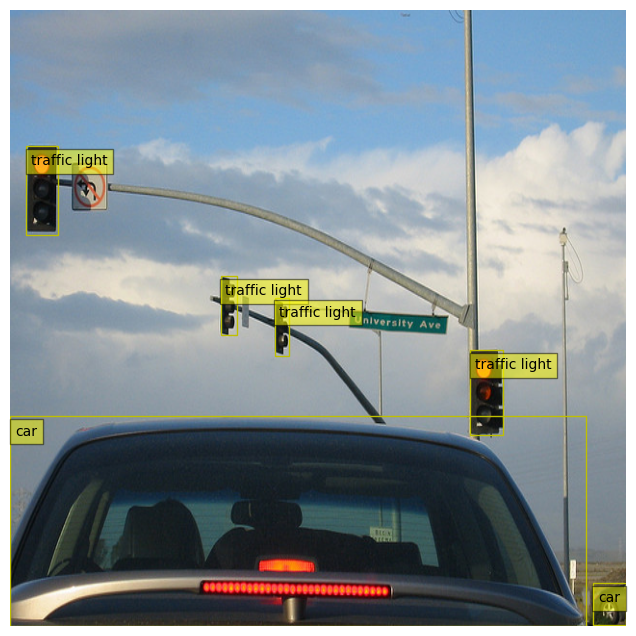

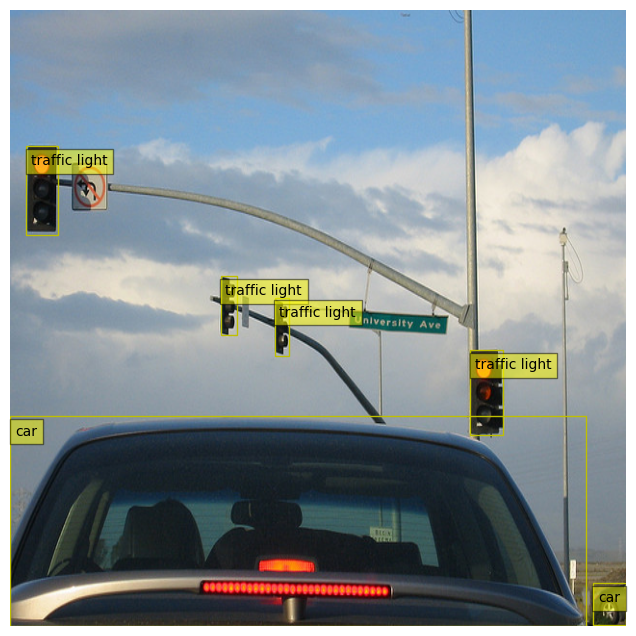

In [66]:
image_resized, target = CDS[18989]

if target['boxes'].numel() ==0:
    print('its a negative image')
else:
    clss = CDS.get_classnames()
    classnames = [clss[i-1] for i in target['labels'].tolist()]

    fig, ax = plt.subplots(figsize=(8,8))
    simg = np.transpose(image_resized.numpy(), (1,2,0))
    ax.imshow(simg)

    fig. ax = CDS.display_bbox(bboxes=target['boxes'], fig=fig, ax=ax,
                              in_format='xyxy', line_width=1, classes=classnames)
    ax.axis('off')
    display(fig)

In [25]:
import torch
from utils.model_utils import display_gt_pred
from pycocotools.coco import COCO

In [31]:
train_ds = CocoDataset(
    image_folder=image_folder,
    annotations_file=annotations_file,
    height=640,
    width=640,
)

In [74]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights

In [76]:
def create_model(num_classes, checkpoint=None, device='cpu'):
    """
    Create a model for object detection using the Faster R-CNN architecture.

    Parameters:
    - num_classes (int): The number of classes for object detection. (Total classes + 1 [for background class])
    - checkpoint (str) : Path to the checkpoint for the pretrained custom model.
    - device (str) : The device to use ('cpu' or 'cuda').

    Returns:
    - model (torchvision.models.detection.fasterrcnn_resnet50_fpn): The created model for object detection.
    """
    # Initialize the Faster R-CNN model with a ResNet-50 backbone
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
        pretrained=True,
        weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT,  # Load the default weights
        pretrained_backbone=True,
    )

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one for our specific number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Load the model from the checkpoint if provided
    if checkpoint:
        checkpoint = torch.load(checkpoint, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])

    # Move the model to the specified device
    model = model.to(device)

    return model

In [78]:
class InferFasterRCNN:
    def __init__(self, num_classes=None, classnames=[]):

        assert type(num_classes) != type(None), "Define number of classes"

        self.num_classes = num_classes  # total_class_no + 1 (for background)

        self.classnames = ["__background__"]
        self.classnames.extend(classnames)

        self.colors = np.random.uniform(0, 255, size=(len(self.classnames), 3))

        assert (
            len(self.classnames) == self.num_classes
        ), f"num_classes: {self.num_classes}, len(classnames): {len(self.classnames)}.\
            num_classes should be equal to count of actual classes in classnames list without background + 1"

    def load_model(self, checkpoint, device="cpu"):
        self.device = device
        self.model = create_model(
            self.num_classes, checkpoint=checkpoint, device=self.device
        )
        self.model = self.model.eval()

    def infer_image(self, transform_info ,detection_threshold=0.5, visualize=False):

        '''
        image : original unscaled image
        '''

        display_unscaled = True
        h_ratio = transform_info['original_height']/transform_info['resized_height']
        w_ratio = transform_info['original_width']/transform_info['resized_width']

        orig_image = transform_info['resized_image']
        orig_image = orig_image.cpu().numpy()
        orig_image = np.transpose(orig_image, (1, 2, 0))
        orig_image = np.ascontiguousarray(orig_image, dtype=np.float32)
        image = torch.unsqueeze(transform_info['resized_image'], 0)

        with torch.no_grad():
            self.model = self.model.to(self.device)
            outputs = self.model(image.to(self.device))

        # load all detection to CPU for further operations
        outputs = [{k: v.to("cpu") for k, v in t.items()} for t in outputs]

        results = {}
        _f_boxes,_f_scores,_f_labels = [],[],[]

        # carry further only if there are detected boxes
        if len(outputs[0]["boxes"]) != 0:
            boxes = outputs[0]["boxes"].data.numpy() # xyxy
            scores = outputs[0]["scores"].data.numpy()
            labels = outputs[0]["labels"].cpu().numpy()

            # filter out boxes according to `detection_threshold`
            for i in range(len(boxes)):
                if scores[i] >= detection_threshold:
                    _f_boxes.append(boxes[i])
                    _f_labels.append(labels[i])
                    _f_scores.append(scores[i])

            boxes,labels,scores = _f_boxes,_f_labels,_f_scores
            #boxes = boxes[scores >= detection_threshold].astype(np.int32)
            draw_boxes = boxes.copy()

            # get all the predicited class names
            pred_classes = [
                self.classnames[i] for i in labels
            ]

            results['unscaled_boxes'] = [[i[0]*w_ratio, i[1]*h_ratio, i[2]*w_ratio, i[3]*h_ratio] for i in boxes] # in original image size
            results['scaled_boxes'] = boxes # in resize image size
            results['scores'] = scores
            results['pred_classes'] = pred_classes
            results['labels'] = labels

            if not display_unscaled:
                # draw the bounding boxes and write the class name on top of it
                for j, box in enumerate(draw_boxes):
                    class_name = pred_classes[j]
                    color = self.colors[self.classnames.index(class_name)]
                    cv2.rectangle(
                        orig_image,
                        (int(box[0]), int(box[1])),
                        (int(box[2]), int(box[3])),
                        color,
                        2,
                    )
                    cv2.putText(
                        orig_image,
                        class_name,
                        (int(box[0]), int(box[1] - 5)),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.7,
                        color,
                        2,
                        lineType=cv2.LINE_AA,
                    )

                if visualize:
                    plt.figure(figsize=(10, 10))
                    plt.imshow(orig_image[:,:,::-1])
                    plt.show()

            else:
                # draw the bounding boxes and write the class name on top of it
                draw_boxes_scaled = results['unscaled_boxes']
                scaled_orig_image = transform_info['original_image']
                scaled_orig_image = scaled_orig_image.cpu().numpy()
                scaled_orig_image = np.transpose(scaled_orig_image, (1, 2, 0))
                scaled_orig_image = np.ascontiguousarray(scaled_orig_image, dtype=np.float32)

                for j, box in enumerate(draw_boxes_scaled):
                    class_name = pred_classes[j]
                    color = self.colors[self.classnames.index(class_name)]
                    cv2.rectangle(
                        scaled_orig_image,
                        (int(box[0]), int(box[1])),
                        (int(box[2]), int(box[3])),
                        color,
                        2,
                    )
                    cv2.putText(
                        scaled_orig_image,
                        class_name,
                        (int(box[0]), int(box[1] - 5)),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.7,
                        color,
                        2,
                        lineType=cv2.LINE_AA,
                    )

                if visualize:
                    plt.figure(figsize=(10, 10))
                    plt.imshow(scaled_orig_image)  # [:,:,::-1])
                    plt.show()

        return results

    def infer_image_path(self, image_path, detection_threshold=0.5, visualize=False):

        image = cv2.imread(image_path)
        orig_image = image.copy()

        # BGR to RGB
        image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
        # make the pixel range between 0 and 1
        image /= 255.0
        # bring color channels to front
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        # convert to tensor
        image = torch.tensor(image, dtype=torch.float).cpu()

        # add batch dimension
        image = torch.unsqueeze(image, 0)
        with torch.no_grad():
            self.model = self.model.to(self.device)
            outputs = self.model(image.to(self.device))

        # load all detection to CPU for further operations
        outputs = [{k: v.to("cpu") for k, v in t.items()} for t in outputs]


        # carry further only if there are detected boxes
        if len(outputs[0]["boxes"]) != 0:
            boxes = outputs[0]["boxes"].data.numpy()
            scores = outputs[0]["scores"].data.numpy()

            # filter out boxes according to `detection_threshold`
            boxes = boxes[scores >= detection_threshold].astype(np.int32)
            draw_boxes = boxes.copy()

            # get all the predicited class names
            pred_classes = [
                self.classnames[i] for i in outputs[0]["labels"].cpu().numpy()
            ]

            # draw the bounding boxes and write the class name on top of it
            for j, box in enumerate(draw_boxes):
                class_name = pred_classes[j]
                color = self.colors[self.classnames.index(class_name)]
                cv2.rectangle(
                    orig_image,
                    (int(box[0]), int(box[1])),
                    (int(box[2]), int(box[3])),
                    color,
                    2,
                )
                cv2.putText(
                    orig_image,
                    class_name,
                    (int(box[0]), int(box[1] - 5)),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.7,
                    color,
                    2,
                    lineType=cv2.LINE_AA,
                )

            if visualize:
                plt.figure(figsize=(10, 10))
                plt.imshow(orig_image[:, :, ::-1])
                plt.show()

        return outputs


    def draw_bounding_boxes(self,image, bboxes, class_labels, figsize=(12,12)):
        class_labels = class_labels.cpu().numpy()
        bboxes = bboxes.cpu().numpy()
        for j, box in enumerate(bboxes):
            label = class_labels[j]
            color = self.colors[label]
            cv2.rectangle(
                    image,
                    (int(box[0]), int(box[1])),
                    (int(box[2]), int(box[3])),
                    (0,200,0),
                    1,
                )
            cv2.putText(
                image,
                self.classnames[int(label)],
                (int(box[0] + 15), int(box[1] + 15)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (0,200,0),
                2,
                lineType=cv2.LINE_AA,
            )

        plt.figure(figsize=figsize)
        plt.imshow(image)
        plt.show()

In [84]:
train_image_dir = "../Dataset/train2017/train2017"
train_annotations_file = "../Dataset/annotations_trainval2017/annotations/instances_train2017.json"

In [86]:
cocoGT = COCO(train_annotations_file)

loading annotations into memory...
Done (t=21.56s)
creating index...
index created!


In [88]:
imgIds = cocoGT.getImgIds() # all image ids
print(len(imgIds))

id = 221

img_info = cocoGT.loadImgs(imgIds[id])[0]
annIds = cocoGT.getAnnIds(imgIds=img_info['id'])
ann_info = cocoGT.loadAnns(annIds)
image_path = os.path.join(train_image_dir,
                          img_info['file_name'])


118287


In [90]:
import copy
transform_info = CocoDataset.transform_image_for_inference(image_path, width=640, height=640)

In [92]:
print(train_ds.get_classnames())

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [94]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [96]:
IF_C = InferFasterRCNN(num_classes=train_ds.get_total_classes_count() + 1,
                       classnames=train_ds.get_classnames())

In [106]:
with torch.no_grad():
    outputs = IF_C.model(transform_info['resized_image'].unsqueeze(0).to(IF_C.device))
    print("Raw Model Outputs:", outputs)

Raw Model Outputs: [{'boxes': tensor([[131.8627, 424.5354, 147.5912, 466.1156],
        [171.4026, 437.3476, 205.8426, 527.4079],
        [134.4855, 438.6855, 152.4026, 472.8233],
        [ 45.2326, 365.5335, 271.6536, 433.5747],
        [ 85.8465, 352.2109, 209.6000, 625.7536],
        [149.6975, 387.7143, 210.5353, 597.3510],
        [144.1658, 274.6583, 640.0000, 474.6818],
        [ 52.9525, 337.3245, 222.1935, 640.0000],
        [448.2917, 229.4518, 604.2701, 517.3864],
        [433.1957, 202.1263, 581.1468, 627.6017],
        [ 17.9470, 402.9531, 199.2218, 640.0000],
        [ 59.6742, 205.8009, 264.7097, 425.0959],
        [ 91.9281,  78.7639, 182.0654, 253.7502],
        [174.7428, 461.2494, 209.5659, 579.3449],
        [449.4534, 254.2805, 630.2563, 522.4216],
        [ 68.7627, 383.0293, 141.8556, 635.7861],
        [125.9071, 399.4303, 195.3584, 640.0000],
        [148.0995, 357.0662, 262.0721, 476.1555],
        [131.2065, 360.4405, 160.5389, 475.2980],
        [138.1926, 3

In [170]:
!python train.py

2024-08-11 12:00:07.653951: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-11 12:00:09.235484: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

  0%|          | 0/19715 [00:00<?, ?batch/s]
Traceback (most recent call last):
  File "C:\Users\Shashwat\ModelDirectory\FasterRCNN-Torchvision-FineTuning\train.py", line 163, in <module>
    train(train_ds, val_ds,
  File "C:\Users\Shashwat\ModelDirectory\FasterRCNN-Torchvision-FineTuning\train.py", line 85, in train
    faster_rcnn_model, optimizer, writer, epoch_loss = train_one_epoch(
                   

In [12]:
from collections import defaultdict
import json

# Example image folder and annotations file
image_folder = "../Dataset/val2017/val2017"
annotations_file = "../Dataset/annotations_trainval2017/annotations/instances_val2017.json"

# Load the annotations file
with open(annotations_file, "r") as f:
    annotations = json.load(f)

# Populate image_ids
image_ids = defaultdict(list)
for i in annotations["images"]:
    image_ids[i["id"]] = i  # Store image metadata with image ID as the key


In [13]:
index = 18 # or any other valid index
image_info = list(image_ids.values())[index]
image_path = os.path.join(image_folder, image_info["file_name"])
print(f"Image Path: {image_path}")

Image Path: ../Dataset/val2017/val2017\000000181666.jpg


In [16]:
image_info["file_name"]

'000000181666.jpg'

In [18]:
print(f"image_info at index {index}: {image_info}")

image_info at index 18: {'license': 3, 'file_name': '000000181666.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000181666.jpg', 'height': 425, 'width': 640, 'date_captured': '2013-11-16 13:58:29', 'flickr_url': 'http://farm3.staticflickr.com/2572/4127484314_23525e6e9c_z.jpg', 'id': 181666}


In [20]:
image_ids = defaultdict(dict)  # change from defaultdict(list) to defaultdict(dict)
for i in annotations["images"]:
    image_ids[i["id"]] = i  # key = image_id

In [22]:
print(f"Image folder: {image_folder}")
print(f"Image info: {image_info}")
image_path = os.path.join(image_folder, image_info["file_name"])


Image folder: ../Dataset/val2017/val2017
Image info: {'license': 3, 'file_name': '000000181666.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000181666.jpg', 'height': 425, 'width': 640, 'date_captured': '2013-11-16 13:58:29', 'flickr_url': 'http://farm3.staticflickr.com/2572/4127484314_23525e6e9c_z.jpg', 'id': 181666}


In [24]:
image_path = os.path.join(image_folder, image_info["file_name"])


In [26]:
image_path

'../Dataset/val2017/val2017\\000000181666.jpg'

In [32]:
image_info

{'license': 3,
 'file_name': '000000181666.jpg',
 'coco_url': 'http://images.cocodataset.org/val2017/000000181666.jpg',
 'height': 425,
 'width': 640,
 'date_captured': '2013-11-16 13:58:29',
 'flickr_url': 'http://farm3.staticflickr.com/2572/4127484314_23525e6e9c_z.jpg',
 'id': 181666}